In [22]:
# ECON204C - Week 1 
# Dynamic Programming - Stochastic Optimal Growth Model
# Retrieved from QuantEcon
# Woongchan Jeon
# April 3 2020

In [31]:
import numpy as np 
import matplotlib.pyplot as plt            # Graph
from scipy.interpolate import interp1d     # Interpolation
from scipy.optimize import minimize_scalar # Optimization

%matplotlib inline

In [32]:
# Define function "maximize"
Asdfghj\=-p098732def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is also the minimizer of -g. 
    The tuple args collects any extra arguments to g.
    args may characterize g. 

    Returns the maximizer and the maximal value.
    """

    objective = lambda x: -g(x, *args)  # Small anonymous function w.r.t. x given *args 
    """
    With *args, any number of extra arguments can be tacked on to your current formal parameters 
    (including zero extra arguments).
    """
    
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [33]:
# Define class "OptimalGrowthModel"

class OptimalGrowthModel:

    def __init__(self,
                 u,               # Utility function
                 f,               # Production function
                 β=0.96,          # Discount factor
                 μ=0,             # Shock location parameter
                 s=0.1,           # Shock scale parameter
                 grid_max=4,      # UB of approx. domain 
                 grid_size=120,   # Grid size
                 shock_size=250,  # Random sample size
                 seed=1234):      # Get the same random numbers

        self.u, self.f, self.β, self.μ, self.s = u, f, β, μ, s

        # Set up grid - Approximation domain and grid for finite element method
        self.grid = np.linspace(1e-4, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))

    def objective(self, c, y, v_array):  
        """
        Objective function of the Bellman Operator.
          * With grid and v_array, we approximate value function
          * y = state variable
          * c = choice variable
        """

        u, f, β, shocks = self.u, self.f, self.β, self.shocks

        v = interp1d(self.grid, v_array)                # Linear Interpolation - Dimension

        return u(c) + β * np.mean(v(f(y - c) * shocks)) # Monte Carlo Integration

In [34]:
# Define Bellman operator "T"

def T(og, v_old):
    """
    The Bellman operator. 
    Updates guess of value function and also computes a v-greedy policy.
      * og is an instance of OptimalGrowthModel
      * v_old is an array representing a guess of the value function
    """
    
    v_new = np.empty_like(v_old)
    v_greedy = np.empty_like(v_old)
    grid = og.grid
    
    for i in range(len(grid)):  # Iterate over grid points
        y = grid[i]

        # Maximize objective function of Bellman operator at state y
        c_star, v_max = maximize(og.objective, 1e-10, y, (y, v_old))  # maximize(g,a,b,arg)
        v_greedy[i] = c_star                                            # Maximizer
        v_new[i] = v_max                                                # Maximum

    return v_greedy, v_new

In [35]:
# Utility and production: Functional form assumption and parametrization

α = 0.4
def fcd(k):
    return k**α 

def logutil(c):
    return np.log(c)

In [36]:
# Create a model with the above primitives and assign it to 'og'

og = OptimalGrowthModel(u=logutil, f=fcd) 

In [37]:
# Value function iteration

def solve_model(og,
                tol=1e-4,        # Tolerance for convergence
                max_iter=1000,   # Maximum number of iterations allowed
                verbose=True,
                print_skip=25):

    # Set up loop
    v_old = np.log(og.grid)  # Initial Guess V_0
    i = 0                # Index for iteration
    error = tol + 1      # Initialize error

    while i < max_iter and error > tol:  # Iterate over operation
        
        v_greedy, v_new = T(og, v_old)         
        """
        With v_old, derive v_new and its associated policy function by applying Bellman operator
        """
        
        error = np.max(np.abs(v_old - v_new))
        """
        Get the distance between v_old and v_new
        """
        
        i += 1
        if verbose and i % print_skip == 0:              # Remainder (i/print_skip)
            print(f"Error at iteration {i} is {error}.")
        v_old = v_new                                    # Update value function 

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new


In [38]:
v_greedy, v_solution = solve_model(og)

Error at iteration 25 is 0.40975776844490497.
Error at iteration 50 is 0.1476753540823772.
Error at iteration 75 is 0.05322171277213883.
Error at iteration 100 is 0.019180930548646558.
Error at iteration 125 is 0.006912744396029069.
Error at iteration 150 is 0.002491330384817303.
Error at iteration 175 is 0.000897867291303811.
Error at iteration 200 is 0.00032358842396718046.
Error at iteration 225 is 0.00011662020561331587.

Converged in 229 iterations.


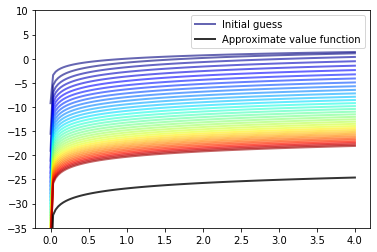

In [39]:
# Draw 

v_old = np.log(og.grid) # Initial guess
n = 35                  # Number of iteration

fig, ax = plt.subplots()

ax.plot(og.grid, v_old, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v_greedy, v_new = T(og, v_old)  # Apply the Bellman operator
    ax.plot(og.grid, v_new, color=plt.cm.jet(i / n), lw=2, alpha=0.6)
    v_old = v_new

ax.plot(og.grid, v_solution, 'k-', lw=2,
        alpha=0.8, label='Approximate value function')

ax.legend()
ax.set_ylim(-35, 10)
plt.show()